<a href="https://colab.research.google.com/github/cheonghf/ML-P4-03/blob/main/Project_SourceCode_P4_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Salary Data CSV from Kaggle to Colab as Dataframe

*   Dataset is sourced from https://www.kaggle.com/datasets/mohithsairamreddy/salary-data/data


In [116]:
import pandas as pd
import numpy as np
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
dataset_ref = kagglehub.dataset_download('mohithsairamreddy/salary-data', path='Salary_Data.csv')

#dataframe salary data 1
df_sd1 = pd.read_csv(dataset_ref)

#copy dataframe salary data 1 to dataframe salary data 2
df_sd2 = df_sd1.copy()

print('Original Data Frame:', df_sd1.shape)
print('Copied Data Frame:', df_sd2.shape)

Original Data Frame: (6704, 6)
Copied Data Frame: (6704, 6)


#Step 1: Pre-Processing of Data

*   Run Everything



View Column of Dataframe

In [117]:
print(df_sd2.columns)

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')


Rename Column of Data Frame to remove spaces

In [118]:
df_sd2.rename(columns={"Education Level": "EduLevel", "Job Title": "JobTitle", "Years of Experience": "YrsExp"}, inplace=True)
print("Updated Columns are:", df_sd2.columns)

Updated Columns are: Index(['Age', 'Gender', 'EduLevel', 'JobTitle', 'YrsExp', 'Salary'], dtype='object')


View Salary Data as Dataframe and Identify any Null Values

In [119]:
# view dataset salary data 2
print(df_sd2)
print("===Data Frame End===")
print('')

# Identify columns with missing valuesin dataset salary data 2
print('Null Values are at:')
print(df_sd2.isnull().sum())
print('')

       Age  Gender           EduLevel               JobTitle  YrsExp    Salary
0     32.0    Male         Bachelor's      Software Engineer     5.0   90000.0
1     28.0  Female           Master's           Data Analyst     3.0   65000.0
2     45.0    Male                PhD         Senior Manager    15.0  150000.0
3     36.0  Female         Bachelor's        Sales Associate     7.0   60000.0
4     52.0    Male           Master's               Director    20.0  200000.0
...    ...     ...                ...                    ...     ...       ...
6699  49.0  Female                PhD  Director of Marketing    20.0  200000.0
6700  32.0    Male        High School        Sales Associate     3.0   50000.0
6701  30.0  Female  Bachelor's Degree      Financial Manager     4.0   55000.0
6702  46.0    Male    Master's Degree      Marketing Manager    14.0  140000.0
6703  26.0  Female        High School        Sales Executive     1.0   35000.0

[6704 rows x 6 columns]
===Data Frame End===

Null 

Removing Null Values from DataFrame

In [120]:
# Remove rows with missing values
df_sd2.dropna(inplace=True)

# Check if columns with missing values are removed
print(df_sd2.isnull().sum())
print('')

# To check if 'na' is string instead of just null
for column in df_sd2.columns:
    na_count = df_sd2[column].astype(str).apply(lambda x: x == 'na').sum()
    if na_count > 0:
        print(f"Column '{column}' contains {na_count} rows with the string 'na'")
    else:
      print(f"Column '{column}' does not contain the string 'na'")

Age         0
Gender      0
EduLevel    0
JobTitle    0
YrsExp      0
Salary      0
dtype: int64

Column 'Age' does not contain the string 'na'
Column 'Gender' does not contain the string 'na'
Column 'EduLevel' does not contain the string 'na'
Column 'JobTitle' does not contain the string 'na'
Column 'YrsExp' does not contain the string 'na'
Column 'Salary' does not contain the string 'na'


Check for Duplicate Entries in Data Frame

In [122]:
# Check for duplicates and create a boolean Series
duplicates = df_sd2.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()

# Calculate the number of non-duplicate rows
num_non_duplicates = len(df_sd2) - num_duplicates

# Calculate the percentage of duplicates
percentage_duplicates = (num_duplicates / len(df_sd2)) * 100

# Print the results
print(f"Number of duplicate rows: {num_duplicates}")
print(f"Number of non-duplicate rows: {num_non_duplicates}")
print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")
print('')

# View the actual duplicate rows:
if num_duplicates > 0:
  print("Duplicate rows:")
  print(df_sd2[duplicates])

Number of duplicate rows: 4911
Number of non-duplicate rows: 1787
Percentage of duplicate rows: 73.32%

Duplicate rows:
       Age  Gender           EduLevel                               JobTitle  \
195   28.0    Male         Bachelor's                Junior Business Analyst   
250   30.0  Female         Bachelor's           Junior Marketing Coordinator   
251   38.0    Male           Master's                   Senior IT Consultant   
252   45.0  Female                PhD                Senior Product Designer   
253   28.0    Male         Bachelor's  Junior Business Development Associate   
...    ...     ...                ...                                    ...   
6699  49.0  Female                PhD                  Director of Marketing   
6700  32.0    Male        High School                        Sales Associate   
6701  30.0  Female  Bachelor's Degree                      Financial Manager   
6702  46.0    Male    Master's Degree                      Marketing Manager   


Filter Duplicate Rows of Data into another Data Frame

In [123]:
# Checking duplicates distribution
duplicate_counts = df_sd2[df_sd2.duplicated()].groupby(df_sd2.columns.tolist()).size().reset_index(name="Count")

# Identifying potential duplication patterns
df_duplicates = df_sd2.groupby(df_sd2.columns.tolist()).size().reset_index(name='Duplicate Count')

Histogram Comparison for 'Age' Duplicate Filter Before Vs After

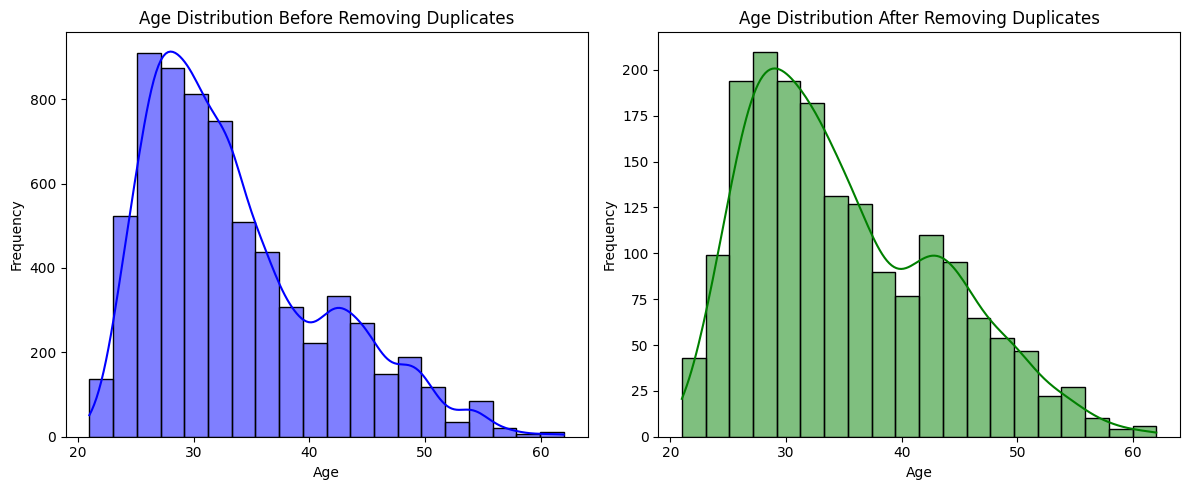

In [124]:
# Visualising Age distribution before and after removing duplicates
plt.figure(figsize=(12, 5))

# Before removing duplicates
plt.subplot(1, 2, 1)
sns.histplot(df_sd2['Age'].dropna(), bins=20, kde=True, color='blue')
plt.title("Age Distribution Before Removing Duplicates")
plt.xlabel("Age")
plt.ylabel("Frequency")

# After removing duplicates
plt.subplot(1, 2, 2)
sns.histplot(df_duplicates['Age'].dropna(), bins=20, kde=True, color='green')
plt.title("Age Distribution After Removing Duplicates")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Histogram Comparison for 'Salary' Duplicate Filter Before Vs After

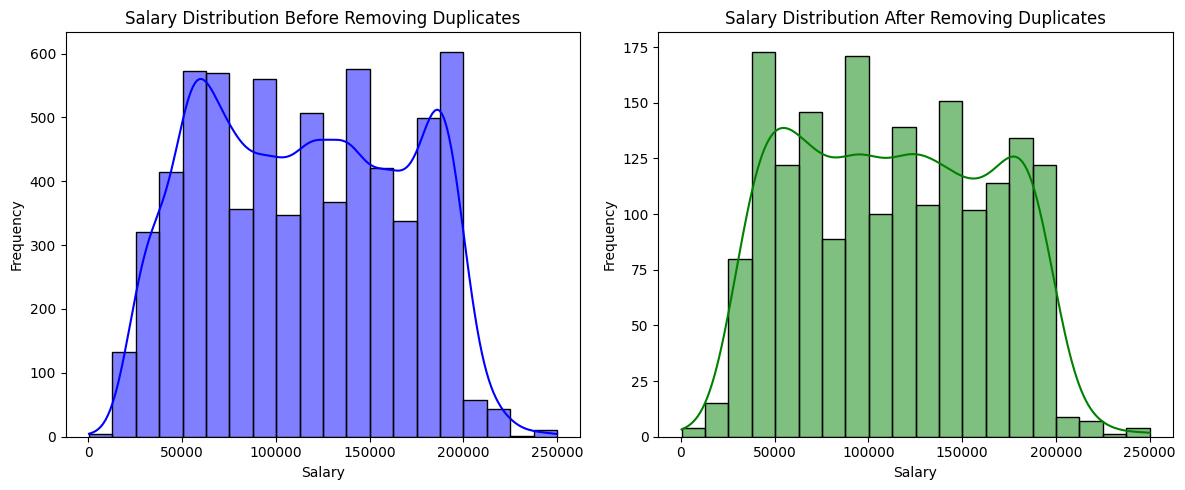

In [125]:
# Visualising salary distribution before and after removing duplicates
plt.figure(figsize=(12, 5))

# Before removing duplicates
plt.subplot(1, 2, 1)
sns.histplot(df_sd2['Salary'].dropna(), bins=20, kde=True, color='blue')
plt.title("Salary Distribution Before Removing Duplicates")
plt.xlabel("Salary")
plt.ylabel("Frequency")

# After removing duplicates
plt.subplot(1, 2, 2)
sns.histplot(df_duplicates['Salary'].dropna(), bins=20, kde=True, color='green')
plt.title("Salary Distribution After Removing Duplicates")
plt.xlabel("Salary")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Histogram Comparison for 'YrsExp' Duplicate Filter Before Vs After

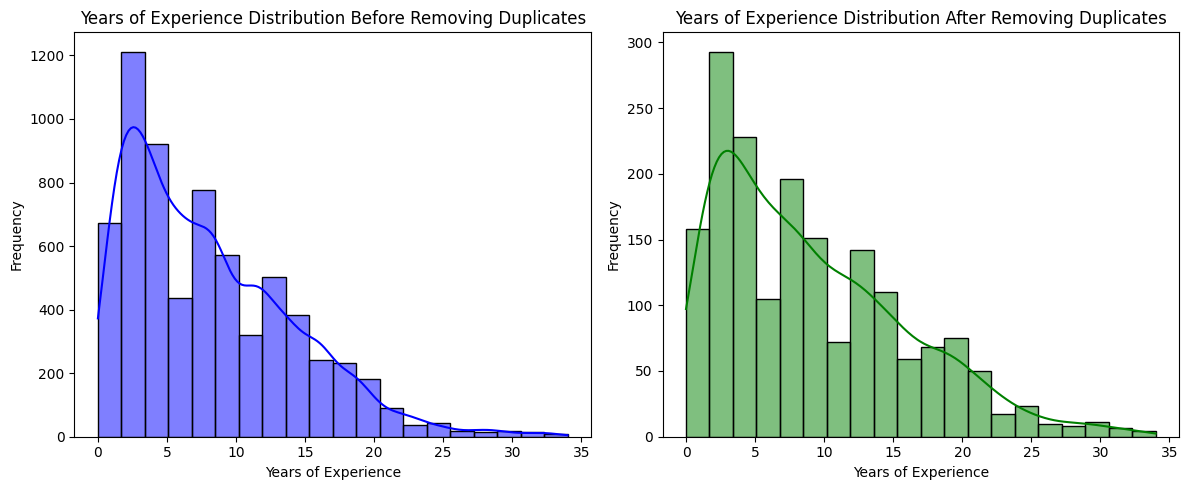

In [126]:
# Visualising Years of Experience distribution before and after removing duplicates
plt.figure(figsize=(12, 5))

# Before removing duplicates
plt.subplot(1, 2, 1)
sns.histplot(df_sd2['YrsExp'].dropna(), bins=20, kde=True, color='blue')
plt.title("Years of Experience Distribution Before Removing Duplicates")
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")

# After removing duplicates
plt.subplot(1, 2, 2)
sns.histplot(df_duplicates['YrsExp'].dropna(), bins=20, kde=True, color='green')
plt.title("Years of Experience Distribution After Removing Duplicates")
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Remove Duplicates from the DataFrame

In [127]:
# Remove duplicate rows and keep the first occurrence
df_sd3 = df_sd2.drop_duplicates(keep='first')

# Reset the index
df_sd3 = df_sd3.reset_index(drop=True)

# Print the shape of the DataFrame before and after removing duplicates
print("Original DataFrame shape:", df_sd2.shape)
print("DataFrame shape after removing duplicates:", df_sd3.shape)

Original DataFrame shape: (6698, 6)
DataFrame shape after removing duplicates: (1787, 6)


Understanding values inside DataFrame of Salary Data

In [128]:
# view dataset salary data 3 information
print(df_sd3.info())
print('')

# Statistic range of dataset salary data 3
print(df_sd3.describe())
print('')

string_columns = df_sd3.select_dtypes(include=['object']).columns

for column in string_columns:
    frequency_table = df_sd3[column].value_counts().to_frame()
    print(f"Column: {column}")
    print(frequency_table)  # Optionally add .to_string() for better formatting
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1787 non-null   float64
 1   Gender    1787 non-null   object 
 2   EduLevel  1787 non-null   object 
 3   JobTitle  1787 non-null   object 
 4   YrsExp    1787 non-null   float64
 5   Salary    1787 non-null   float64
dtypes: float64(3), object(3)
memory usage: 83.9+ KB
None

               Age       YrsExp         Salary
count  1787.000000  1787.000000    1787.000000
mean     35.139899     9.156128  113184.659765
std       8.213045     6.844924   51596.536766
min      21.000000     0.000000     350.000000
25%      29.000000     3.000000   70000.000000
50%      33.000000     8.000000  110000.000000
75%      41.000000    13.000000  160000.000000
max      62.000000    34.000000  250000.000000

Column: Gender
        count
Gender       
Male      966
Female    814
Other       7


Column: EduL

To determine if 'Other' in 'Gender' column is significant ( less than 2%)

In [129]:
gender_counts = df_sd3['Gender'].value_counts()
other_percentage = (gender_counts['Other'] / len(df_sd3)) * 100
print(f"Percentage of 'Other' in Gender: {other_percentage:.2f}%")

Percentage of 'Other' in Gender: 0.39%


Remove 'Other' and its relevant row of data from the column 'Gender'

In [130]:
# Filter out rows where Gender is 'Other'
df_sd3 = df_sd3[df_sd3['Gender'] != 'Other']

# Reset the index if needed
df_sd3 = df_sd3.reset_index(drop=True)

# Display unique values after cleaning
print('Updated Unique Values under "Gender":', df_sd3['Gender'].unique())

# Display shape
print("DataFrame shape after cleaning Gender:", df_sd3.shape)

Updated Unique Values under "Gender": ['Male' 'Female']
DataFrame shape after cleaning Gender: (1780, 6)


Standardise naming of Data under the column 'EduLevel'

In [131]:
# Define a mapping dictionary for standardisation
education_mapping = {
    "Bachelor's Degree": "BachelorDegree",
    "Bachelor's": "BachelorDegree",
    "Master's Degree": "MasterDegree",
    "Master's": "MasterDegree",
    "phD": "PhD",
    "High School": "HighSchool"
}

# Apply mapping to clean the 'EduLevel' column
df_sd3['EduLevel'] = df_sd3['EduLevel'].replace(education_mapping)

# Display unique values after cleaning
print('Updated Unique Values in Data Frame:', df_sd3['EduLevel'].unique())

Updated Unique Values in Data Frame: ['BachelorDegree' 'MasterDegree' 'PhD' 'HighSchool']


# Step 2: Analsying the DataSet (Run Step 1 Before this)

Grouped Bar Chart: Gender Breakdown by Education Level

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.countplot(x='EduLevel', hue='Gender', data=df_sd3)
plt.title('Breakdown of Gender by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Histogram: Age Distribution of Dataset

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(df_sd3['Age'], bins=20, kde=True)  # 'bins' controls the number of bars, 'kde' adds a density curve
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

BoxPlot: Salary Distribution by Gender

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(x='Gender', y='Salary', data=df_sd3)
plt.title('Salary Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Salary')
plt.tight_layout()
plt.show()

Box Plot Salary Distribution by Education Level

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='EduLevel', y='Salary', data=df_sd3)
plt.title('Salary Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Scatterplot of Salary Distribution by Years of Experience

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='YrsExp', y='Salary', data=df_sd3)
plt.title('Salary Distribution by Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.tight_layout()
plt.show()

Scatterplot of Salary Distribution by Age

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='Salary', data=df_sd3)
plt.title('Salary Distribution by Age')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.tight_layout()
plt.show()

# Step 3: Machine Learning Algorithm Implementation with Raw Data (Run Step 1 Before this)

*   Encode the relevant column of data
*   Spilt Dataset between training and test
*   4 different types of Machine Learning Algorithm to identify best two




Copy Dataframe for Step 3

In [ ]:
df_sd4 = df_sd3.copy()

print('Original Data Frame:', df_sd3.shape)
print('Copied Data Frame:', df_sd4.shape)
print()
df_sd4.columns

Encode raw data

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Drop 'JobTitle' (high cardinality, too specific)
df_sd5 = df_sd4.drop(columns=['JobTitle'])

# Separate features and target
X = df_sd5.drop(columns=['Salary'])
y = df_sd5['Salary']

# Identify feature types
categorical_ordinal = ['EduLevel']  # Ordinal categories
categorical_nominal = ['Gender']  # Nominal categories
numerical_cols = ['Age', 'YrsExp']

# Apply Label Encoding to ordinal categorical variables
for col in categorical_ordinal:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Apply OneHotEncoding to nominal categorical variables
ohe = OneHotEncoder(sparse_output=False)  # Avoid dummy variable trap
X_encoded = ohe.fit_transform(X[categorical_nominal])
encoded_feature_names = ohe.get_feature_names_out(categorical_nominal)

# Scale numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

# Combine all transformed features
X_processed = np.hstack((X_scaled, X[categorical_ordinal].values, X_encoded))

# Convert to DataFrame for clarity
X_final = pd.DataFrame(X_processed, columns=numerical_cols + categorical_ordinal + list(encoded_feature_names))

Spilting of Training Data (Must Run before Algorithm)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

Algorithm 1: LinearRegression (Train)

In [ ]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
lr_model = LinearRegression() # Initialise
lr_model.fit(X_train, y_train) # Train the model on training data

# Predict salaries on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate error metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)   # Mean Absolute Error
mse_lr = mean_squared_error(y_test, y_pred_lr)    # Mean Squared Error
r2_lr = r2_score(y_test, y_pred_lr)               # R-squared score

# Print performance metrics
print("Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")

Algorithm 2: DecisionTreeRegressor (Train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree Regressor
dtr_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dtr_model.fit(X_train, y_train)

# Predict salaries on the test set
y_pred_dtr = dtr_model.predict(X_test)

# Calculate error metrics
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)   # Mean Absolute Error
mse_dtr = mean_squared_error(y_test, y_pred_dtr)    # Mean Squared Error
r2_dtr = r2_score(y_test, y_pred_dtr)               # R-squared score

# Evaluate performance
print("Decision Tree Performance:")
print(f"Mean Absolute Error (MAE): {mae_dtr:.2f}")
print(f"Mean Squared Error (MSE): {mse_dtr:.2f}")
print(f"R² Score: {r2_dtr:.4f}")

Algorithm 3: RandomForestRegressor (Train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
# rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

# Predict salaries on the test set
y_pred_rfr = rfr_model.predict(X_test)

# Evaluate performance
mae_rfr = mean_absolute_error(y_test,y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)    # Mean Squared Error
r2_rfr = r2_score(y_test, y_pred_rfr)

# Print results
print("Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_rfr:.2f}")
print(f"Mean Squared Error (MSE): {mse_rfr:.2f}")
print(f"R² Score: {r2_rfr:.4f}")

Algorithm 4: XGBoost

In [ ]:
from xgboost import XGBRegressor

# Train Random Forest Regressor
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict salaries on the test set
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Performance")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

#Step 4: Feature Extraction (Run Step 1 Before this)

*   Run Everything


**Part 1 of 2: Clustering JobTitles to Industry**

Extract Unique JobTitles & Preprocess Text

*   Lowercase transformation
*   Special character removal (if needed)
*   Convert text into numerical format using TF-IDF vectorisation

Determine Optimal Number of Clusters

*   Use Elbow Method to find the best cluster number based on inertia.
*   Use Silhouette Score Analysis to validate the best choice.

In [132]:
df_sd6 = df_sd3.copy()

print('Original Data Frame:', df_sd3.shape)
print('Copied Data Frame:', df_sd6.shape)
print()

print(df_sd6['JobTitle'].value_counts())

Original Data Frame: (1780, 6)
Copied Data Frame: (1780, 6)

JobTitle
Software Engineer Manager    127
Full Stack Engineer          120
Senior Project Engineer       94
Senior Software Engineer      94
Data Scientist                80
                            ... 
Financial Advisor              1
Junior Designer                1
Chief Technology Officer       1
Technical Recruiter            1
Delivery Driver                1
Name: count, Length: 191, dtype: int64


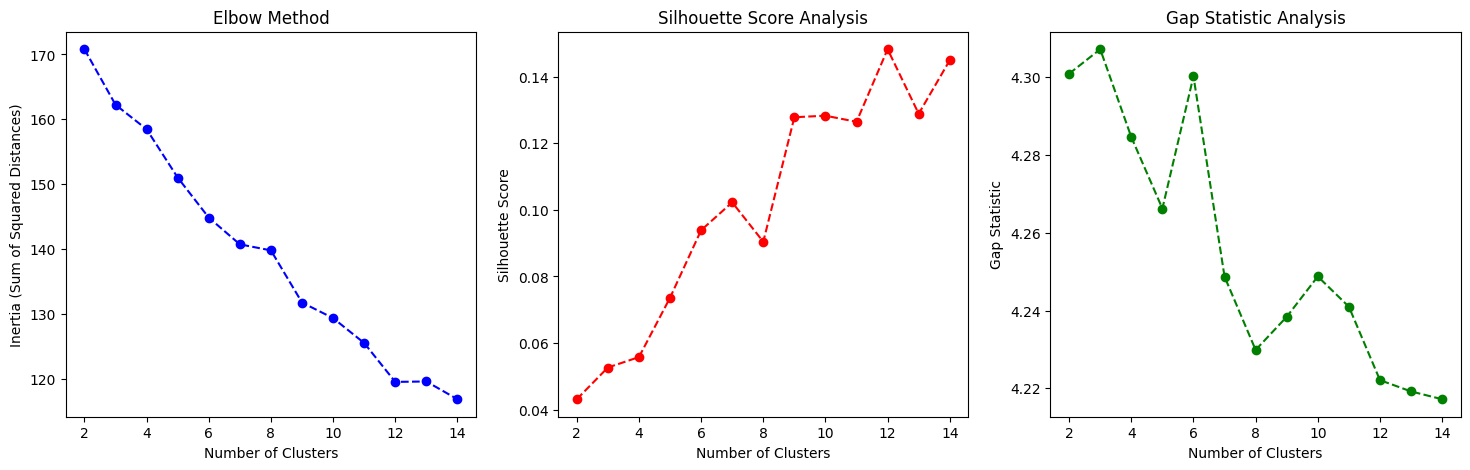

Optimal values found by each method:


(12, 12, 3)

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# Extract unique job titles again after reset
job_titles = df_sd6['JobTitle'].dropna().unique()

# Convert job titles to lowercase for standardization
cleaned_titles = [title.lower() for title in job_titles]

# Convert text data into numerical format using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_job = vectorizer.fit_transform(cleaned_titles)

# Define cluster range dynamically
min_k = 2  # Minimum clusters
max_k = 15  # Maximum clusters

# Initialize lists to store results
inertia = []
silhouette_scores = []
gap_values = []

# Compute Gap Statistic method
def gap_statistic(X_job, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_job)
    cluster_dispersion = np.mean([np.min(pairwise_distances(X_job, [center]), axis=1) for center in kmeans.cluster_centers_])

    # Generate reference random dataset
    random_X = np.random.uniform(X_job.min(), X_job.max(), X_job.shape)
    random_dispersion = np.mean([np.min(pairwise_distances(random_X, [center]), axis=1) for center in kmeans.cluster_centers_])

    return random_dispersion - cluster_dispersion

# Loop through cluster range and compute values
cluster_range = range(min_k, max_k)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_job)

    # Store values
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_job, kmeans.labels_))
    gap_values.append(gap_statistic(X_job, k))

# Determine optimal clusters based on each method
optimal_k_elbow = cluster_range[np.argmax(np.diff(inertia))]  # Elbow method approximation
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]  # Best silhouette score
optimal_k_gap = cluster_range[np.argmax(gap_values)]  # Best gap statistic

# Plot the results
plt.figure(figsize=(18, 5))

# Elbow Method Plot
plt.subplot(1, 3, 1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method')

# Silhouette Score Plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')

# Gap Statistic Plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, gap_values, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic Analysis')

# Display plots
plt.show()

# Print the optimal values found by each method
print("Optimal values found by each method:")
optimal_k_elbow, optimal_k_silhouette, optimal_k_gap

Further Testing to determine which k to use

In [134]:
# Apply K-Means clustering with k=12 (Refined Job Categories)
kmeans_refined = KMeans(n_clusters=12, random_state=42, n_init=10)
clusters_refined = kmeans_refined.fit_predict(X_job)

# Apply K-Means clustering with k=2 (Broader Job Categories)
kmeans_broad = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_broad = kmeans_broad.fit_predict(X_job)

# Map job titles to clusters for both cases
df_sd6['Industry (Refined - k=12)'] = df_sd6['JobTitle'].map(dict(zip(job_titles, clusters_refined)))
df_sd6['Industry (Broad - k=2)'] = df_sd6['JobTitle'].map(dict(zip(job_titles, clusters_broad)))

# Define industry mappings (Placeholder Names)
industry_mapping_refined = {i: f"Industry {i+1}" for i in range(12)}
industry_mapping_broad = {0: "General Industry A", 1: "General Industry B"}

# Apply mappings
df_sd6['Industry (Refined - k=12)'] = df_sd6['Industry (Refined - k=12)'].map(industry_mapping_refined)
df_sd6['Industry (Broad - k=2)'] = df_sd6['Industry (Broad - k=2)'].map(industry_mapping_broad)

# Display the DataFrame with both refined (k=12) and broad (k=2) industries
df_sd6[['JobTitle', 'Industry (Refined - k=12)', 'Industry (Broad - k=2)']]

# df_sd6.to_csv('cluster_compare_job_titles.csv', index=False)

,JobTitle,Industry (Refined - k=12),Industry (Broad - k=2)
0,Software Engineer,Industry 5,General Industry A
1,Data Analyst,Industry 6,General Industry A
2,Senior Manager,Industry 3,General Industry A
3,Sales Associate,Industry 10,General Industry A
4,Director,Industry 4,General Industry B
...,...,...,...
1775,Digital Marketing Manager,Industry 3,General Industry A
1776,Sales Manager,Industry 10,General Industry A
1777,Director of Marketing,Industry 4,General Industry B
1778,Sales Director,Industry 10,General Industry B


In [135]:
# Group job titles by their assigned cluster (Industry k=12)
industry_job_distribution = df_sd6.groupby("Industry (Refined - k=12)")["JobTitle"].unique()

# Convert to DataFrame for better readability
df_industry_job = industry_job_distribution.reset_index()
df_industry_job.columns = ["Cluster", "Job Titles"]

df_industry_job

,Cluster,Job Titles
0,Industry 1,"[Marketing Coordinator, Event Coordinator, Sen..."
1,Industry 10,"[Sales Associate, Sales Manager, Sales Directo..."
2,Industry 11,"[Human Resources Director, Director of Human R..."
3,Industry 12,"[Business Analyst, Business Intelligence Analy..."
4,Industry 2,"[Senior Scientist, Customer Service Rep, Data ..."
5,Industry 3,"[Senior Manager, Product Manager, HR Manager, ..."
6,Industry 4,"[Director, Operations Director, Director of Ma..."
7,Industry 5,"[Software Engineer, Senior Engineer, Software ..."
8,Industry 6,"[Data Analyst, Marketing Analyst, Financial An..."
9,Industry 7,"[Software Developer, Junior Developer, Web Dev..."


**Part 2 of 2: Clustering JobTitles to Industry**

Apply K-Means Clustering with Optimal Clusters

*   Fit the model using the finalised number of clusters.
*   Assign each job title to a cluster.

Map Clusters to Industry Names

*   Define a manual mapping from cluster numbers to industry labels.
*   Apply this mapping to assign industry names to job titles.

Update the Original DataFrame

*   Merge the clustered job titles back into the dataset with a new column "Industry"

In [136]:
# Remove column for broad
df_sd6 = df_sd6.drop('Industry (Broad - k=2)', axis=1)
df_sd6 = df_sd6.drop('Industry (Refined - k=12)', axis=1)

# Select optimal clusters based on highest silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]

# Apply K-Means clustering with the optimized number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(X_job)

# Map job titles to clusters
job_cluster_mapping = dict(zip(job_titles, clusters_optimal))
df_sd6['Industry'] = df_sd6['JobTitle'].map(job_cluster_mapping)

# Define refined industry names based on job title distribution
industry_mapping_refined = {
    0: "Marketing & Communications",
    1: "Research & Customer Support",
    2: "Executive & Senior Management",
    3: "Technology & IT Services",
    4: "Data Science & Analytics",
    5: "Healthcare & Life Sciences",
    6: "Finance & Accounting",
    7: "Operations & Supply Chain",
    8: "Education & Training",
    9: "Sales & Business Development",
    10: "Human Resources & Administration",
    11: "Business Strategy & Consulting"
}
# Apply industry mapping
df_sd6['Industry'] = df_sd6['Industry'].map(industry_mapping_refined)

print(df_sd6)

       Age  Gender        EduLevel                   JobTitle  YrsExp  \
0     32.0    Male  BachelorDegree          Software Engineer     5.0   
1     28.0  Female    MasterDegree               Data Analyst     3.0   
2     45.0    Male             PhD             Senior Manager    15.0   
3     36.0  Female  BachelorDegree            Sales Associate     7.0   
4     52.0    Male    MasterDegree                   Director    20.0   
...    ...     ...             ...                        ...     ...   
1775  43.0  Female    MasterDegree  Digital Marketing Manager    15.0   
1776  27.0    Male      HighSchool              Sales Manager     2.0   
1777  33.0  Female  BachelorDegree      Director of Marketing     8.0   
1778  37.0    Male  BachelorDegree             Sales Director     7.0   
1779  30.0  Female  BachelorDegree              Sales Manager     5.0   

        Salary                       Industry  
0      90000.0       Data Science & Analytics  
1      65000.0     Healthca

Clustering Age to Generation

Frequency of each generation type:
Generation
Millennials         1015
GenZ                 438
GenX                 321
BabyBoomer             6
SilentGeneration       0
Name: count, dtype: int64



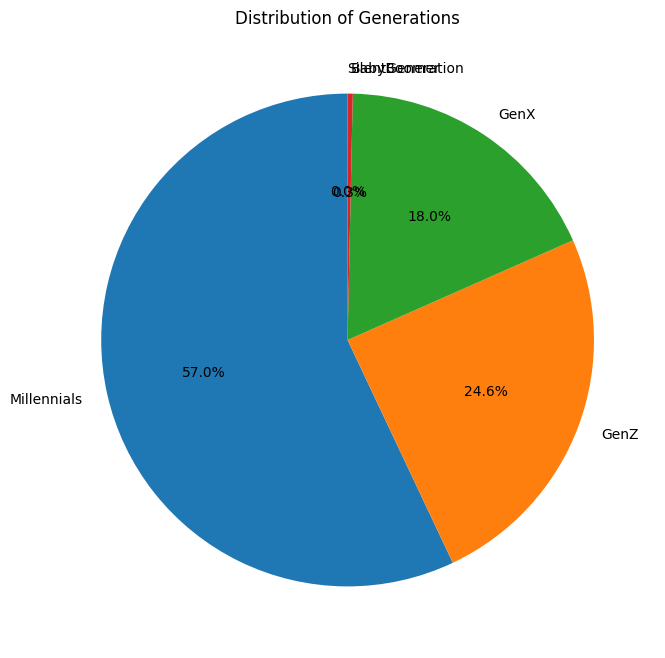


(1780, 9)
Updated Columns of Data Set Index(['Age', 'Gender', 'EduLevel', 'JobTitle', 'YrsExp', 'Salary', 'Industry',
       'BirthYear', 'Generation'],
      dtype='object')


In [137]:
# Define the reference year based on the dataset's last update
reference_year = 2023

# Calculate the Birth Year
df_sd6['BirthYear'] = reference_year - df_sd6['Age']

# Define bins and labels for generation categories
bins = [0, 1943, 1964, 1979, 1994, float('inf')]
labels = ['SilentGeneration', 'BabyBoomer', 'GenX', 'Millennials', 'GenZ']

# Assign generations based on Birth Year
df_sd6['Generation'] = pd.cut(df_sd6['BirthYear'], bins=bins, labels=labels, right=True)

# Get the frequency of each label under 'Generation'
generation_counts = df_sd6['Generation'].value_counts()

# Print the frequency
print("Frequency of each generation type:")
print(generation_counts)
print('')

# Create a pie chart
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.pie(generation_counts, labels=generation_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Generations')
plt.show()
print('')

print(df_sd6.shape)
print("Updated Columns of Data Set", df_sd6.columns)

Clustering Years of Experience to Seniority

In [138]:
def assign_seniority(years):
    if years <= 3:
        return "Entry"
    elif 4 <= years <= 6:
        return "Junior"
    elif 7 <= years <= 10:
        return "Mid"
    elif 11 <= years <= 15:
        return "Senior"
    else:
        return "Executive"

# Apply the mapping function to create the new 'Seniority' column
df_sd6['Seniority'] = df_sd6['YrsExp'].apply(assign_seniority)

# Get the frequency of each label under 'Generation'
seniority_counts = df_sd6['Seniority'].value_counts()

# Print the frequency
print("Frequency of each Seniority:")
print(seniority_counts)
print('')

df_sd6.columns

Frequency of each Seniority:
Seniority
Entry        449
Mid          346
Junior       333
Executive    329
Senior       323
Name: count, dtype: int64



Index(['Age', 'Gender', 'EduLevel', 'JobTitle', 'YrsExp', 'Salary', 'Industry',
       'BirthYear', 'Generation', 'Seniority'],
      dtype='object')

Encode Categorical Features and Scale the features

In [139]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Drop 'JobTitle' (high cardinality, too specific)
df_sd7 = df_sd6.drop(columns=['JobTitle', 'BirthYear'])

# Separate features and target
X = df_sd7.drop(columns=['Salary'])
y = df_sd7['Salary']

# Identify feature types
categorical_ordinal = ['EduLevel', 'Generation', 'Seniority']  # Ordinal categories
categorical_nominal = ['Gender', 'Industry']  # Nominal categories
numerical_cols = ['Age', 'YrsExp']

# Apply Label Encoding to ordinal categorical variables
for col in categorical_ordinal:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Apply OneHotEncoding to nominal categorical variables
ohe = OneHotEncoder(sparse_output=False)  # Avoid dummy variable trap
X_encoded = ohe.fit_transform(X[categorical_nominal])
encoded_feature_names = ohe.get_feature_names_out(categorical_nominal)

# Scale numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

# Combine all transformed features
X_processed = np.hstack((X_scaled, X[categorical_ordinal].values, X_encoded))

# Convert to DataFrame for clarity
X_final = pd.DataFrame(X_processed, columns=numerical_cols + categorical_ordinal + list(encoded_feature_names))

print(X_final)

           Age    YrsExp  EduLevel  Generation  Seniority  Gender_Female  \
0    -0.381613 -0.607067       0.0         3.0        2.0            0.0   
1    -0.870472 -0.901223       2.0         2.0        0.0            1.0   
2     1.207181  0.863710       3.0         1.0        4.0            0.0   
3     0.107247 -0.312912       0.0         3.0        3.0            1.0   
4     2.062685  1.599098       2.0         1.0        1.0            0.0   
...        ...       ...       ...         ...        ...            ...   
1775  0.962751  0.863710       2.0         3.0        4.0            1.0   
1776 -0.992687 -1.048301       1.0         2.0        0.0            0.0   
1777 -0.259398 -0.165834       0.0         3.0        3.0            1.0   
1778  0.229462 -0.312912       0.0         3.0        3.0            0.0   
1779 -0.626042 -0.607067       0.0         3.0        2.0            1.0   

      Gender_Male  Industry_Business Strategy & Consulting  \
0             1.0        

Correlation Heat Map Matrix (On hold)

In [ ]:
'''
# Show correlation heat map and matrix
df_corr = X_final[['Age','YrsExp','Salary','EduLevel','Seniority']]

# Calculate the correlation matrix
corrmat = df_corr.corr()

# Title
plt.title("Correlation Heatmap")

# Generate the heatmap
sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()
'''

#Step 5: Machine Learning Algorithm Implementation with Additional Features (Run Step 4 Before this)
*   Run the Algorithm of your choice



Spilting of Training Data (Must Run before Algorithm)

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

Algorithm 3: RandomForestRegressor (Train)

In [141]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
# rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

# Predict salaries on the test set
y_pred_rfr = rfr_model.predict(X_test)

# Evaluate performance
mae_rfr = mean_absolute_error(y_test,y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)    # Mean Squared Error
r2_rfr = r2_score(y_test, y_pred_rfr)

# Print results
print("Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_rfr:.2f}")
print(f"Mean Squared Error (MSE): {mse_rfr:.2f}")
print(f"R² Score: {r2_rfr:.4f}")

Random Forest Regressor Performance:
Mean Absolute Error (MAE): 13008.56
Mean Squared Error (MSE): 417194437.89
R² Score: 0.8528


Algorithm 4: XGBoost

In [142]:
from xgboost import XGBRegressor

# Train Random Forest Regressor
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict salaries on the test set
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Performance")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

XGBoost Performance
Mean Absolute Error (MAE): 12784.67
Mean Squared Error (MSE): 369126250.45
R² Score: 0.8698


# Step 6: Fine-Tunning Machine Learning Algorithm (Run Step 5 Before this)

*   According to your Algorithm of your Choice
*   Pick either one of the 2



 **Algorithm 3** (Choose 1 of 2): Fine-Tuning with Grid Search (Exhaustive)
*   Grid Search tests all possible combinations of specified hyperparameters.



In [ ]:
from sklearn.model_selection import GridSearchCV

fine_tune_choice = 1

# Define the parameter grid
param_grid_rfr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform Grid Search
grid_search_rfr = GridSearchCV(rfr_model, param_grid_rfr, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search_rfr.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search_rfr.best_params_)
print("Best MAE:", -grid_search_rfr.best_score_)

**Algorithm 3** (Choose 2 of 2): Fine-Tuning with Random Search (Faster)
*   Random Search randomly samples hyperparameters instead of testing all combinations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

fine_tune_choice = 2

# Define the parameter grid with distributions
param_dist_rfr = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

# Perform Randomized Search
random_search_rfr = RandomizedSearchCV(rfr_model, param_dist_rfr, n_iter=20, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
random_search_rfr.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", random_search_rfr.best_params_)
print("Best MAE:", -random_search_rfr.best_score_)


 **Algorithm 4** (Choose 1 of 2): Fine-Tuning with Grid Search (Exhaustive)

In [ ]:
from sklearn.model_selection import GridSearchCV

fine_tune_choice = 1

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best MAE:", -grid_search_xgb.best_score_)

 **Algorithm 4** (Choose 2 of 2): Fine-Tuning with Random Search (Faster)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

fine_tune_choice = 2

# Define the parameter distribution
param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5)
}

# Randomized Search
random_search_xgb = RandomizedSearchCV(xgb_model, param_dist_xgb, n_iter=20, scoring='neg_mean_absolute_error', cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", random_search_xgb.best_params_)
print("Best MAE:", -random_search_xgb.best_score_)

# Step 7: Retraining of Algorithm Model (Run only after Step 6)

*   Find the Algorithm of Choice
*   Retrain First
*   Feature Importance Comparison



**Algorithm 3** (Part 1 of 2): Random Forest Regressor (Retrain)

In [ ]:
if fine_tune_choice == 1:
  best_params = grid_search_rfr.best_params_
elif fine_tune_choice == 2:
  best_params = random_search_rfr.best_params_

best_model_rfr = RandomForestRegressor(**best_params, random_state=42)
best_model_rfr.fit(X_train, y_train)

# Predict and evaluate
y_pred_rfr = best_model_rfr.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_rfr)
mse_tuned = mean_squared_error(y_test, y_pred_rfr)
r2_tuned = r2_score(y_test, y_pred_rfr)

print(f"Tuned Model MAE: {mae_tuned:.2f}")
print(f"Tuned Model MSE: {mse_tuned:.2f}")
print(f"Tuned Model R² Score: {r2_tuned:.4f}")

 Algorithm 3 (Part 2 of 2): Random Forest Regressor (View Feature Importance)

In [ ]:
# Feature importances from both models
feature_importances_1 = rfr_model.feature_importances_
feature_importances_2 = best_model_rfr.feature_importances_
feature_names = X_final.columns

# Sort feature importance values
sorted_idx_1 = np.argsort(feature_importances_1)[::-1]
sorted_idx_2 = np.argsort(feature_importances_2)[::-1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot first model's feature importance
axes[0].bar(range(len(feature_importances_1)), feature_importances_1[sorted_idx_1], tick_label=np.array(feature_names)[sorted_idx_1])
axes[0].set_xticklabels(np.array(feature_names)[sorted_idx_1], rotation=90)
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Importance")
axes[0].set_title("Feature Importance in Random Forest (Before Tune)")

# Plot second model's feature importance
axes[1].bar(range(len(feature_importances_2)), feature_importances_2[sorted_idx_2], tick_label=np.array(feature_names)[sorted_idx_2])
axes[1].set_xticklabels(np.array(feature_names)[sorted_idx_2], rotation=90)
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Importance")
axes[1].set_title("Feature Importance in Random Forest (After Tune)")

# Show the plots
plt.tight_layout()
plt.show()

 **Algorithm 4** (Part 1 of 2): XGBRegressor (Retrain)

In [ ]:
if fine_tune_choice == 1:
  best_params = grid_search_xgb.best_params_
elif fine_tune_choice == 2:
  best_params = random_search_xgb.best_params_

best_model_xgb = XGBRegressor(**best_params, random_state=42)
best_model_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = best_model_xgb.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_xgb)
mse_tuned = mean_squared_error(y_test, y_pred_xgb)
r2_tuned = r2_score(y_test, y_pred_xgb)

print(f"Tuned Model MAE: {mae_tuned:.2f}")
print(f"Tuned Model MSE: {mse_tuned:.2f}")
print(f"Tuned Model R² Score: {r2_tuned:.4f}")

 Algorithm 4 (Part 2 of 2): XGBRegressor (View Feature Importance)

In [ ]:
# Feature importances from both models
feature_importances_1 = xgb_model.feature_importances_
feature_importances_2 = best_model_xgb.feature_importances_
feature_names = X_final.columns

# Sort feature importance values
sorted_idx_1 = np.argsort(feature_importances_1)[::-1]
sorted_idx_2 = np.argsort(feature_importances_2)[::-1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot first model's feature importance
axes[0].bar(range(len(feature_importances_1)), feature_importances_1[sorted_idx_1], tick_label=np.array(feature_names)[sorted_idx_1])
axes[0].set_xticklabels(np.array(feature_names)[sorted_idx_1], rotation=90)
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Importance")
axes[0].set_title("Feature Importance in XGBRegressor (Before Tune)")

# Plot second model's feature importance
axes[1].bar(range(len(feature_importances_2)), feature_importances_2[sorted_idx_2], tick_label=np.array(feature_names)[sorted_idx_2])
axes[1].set_xticklabels(np.array(feature_names)[sorted_idx_2], rotation=90)
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Importance")
axes[1].set_title("Feature Importance in XGBRegressor (After Tune)")

# Show the plots
plt.tight_layout()
plt.show()

# Step 8: Exploring Combining of Two Algorithms (Run only after Step 7)

In [ ]:
# Define Weights Based on Performance (higher R² → higher weight)
w_rfr = r2_score(y_test, y_pred_rfr)
w_xgb = r2_score(y_test, y_pred_xgb)

# Normalize Weights
total_weight = w_rfr + w_xgb
w_rfr /= total_weight
w_xgb /= total_weight

# Weighted Average
y_pred_weighted = (w_rfr * y_pred_rfr) + (w_xgb * y_pred_xgb)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred_weighted)
mse = mean_squared_error(y_test, y_pred_weighted)
r2 = r2_score(y_test, y_pred_weighted)

print("Ensemble Model Performance (Weighted Averaging):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Extract the best parameters from tuning
rf_best_params = {k: v for k, v in best_params.items() if k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']}
xgb_best_params = {k: v for k, v in best_params.items() if k in ['n_estimators', 'learning_rate', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree']}

# Define Base Models (Using Correct Parameters for Each Model)
base_models = [
    ('rf', RandomForestRegressor(**rf_best_params, random_state=42)),
    ('xgb', XGBRegressor(**xgb_best_params, random_state=42))
]

# Meta Model (Final Predictor)
meta_model = LinearRegression()

# Stacking Regressor
stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_reg.fit(X_train, y_train)

# Predict on Test Data
y_pred_stack = stacking_reg.predict(X_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred_stack)
mse = mean_squared_error(y_test, y_pred_stack)
r2 = r2_score(y_test, y_pred_stack)

print("Stacking Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# Step 9: Save and Deploy the Model

Save the Model

In [ ]:
import joblib

# Save the model
joblib.dump(stacking_reg, 'stacking_regressor.pkl')

Load the Trained Model

In [ ]:
# Load the trained model
stacking_reg = joblib.load('stacking_regressor.pkl')

 Prepare New Data for Prediction

In [ ]:
# Example new data (should match feature columns of X_train)
new_data = {
    'Age': [30],  # Example Age
    'YrsExp': [5],  # Example Years of Experience
    'EduLevel': ['BachelorDegree'],  # Example Education Level
    'Gender': ['Male'],  # Example Gender
    'Industry': ['Technology & IT Services'],  # Example Industry
    'Generation': ['Millennials'],  # Example Generation
    'Seniority': ['Junior']  # Example Seniority Level
}

# Convert new data to DataFrame
df_new = pd.DataFrame(new_data)

Preprocess New Data (Apply Same Encoding and Scaling)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Load encoders used during training
le_education = LabelEncoder()
le_education.classes_ = np.array(['HighSchool', 'BachelorDegree', 'MasterDegree', 'PhD'])
df_new['EduLevel'] = le_education.transform(df_new['EduLevel'])

le_generation = LabelEncoder()
le_generation.classes_ = np.array(['SilentGeneration', 'BabyBoomer', 'GenX', 'Millennials', 'GenZ'])
df_new['Generation'] = le_generation.transform(df_new['Generation'])

le_seniority = LabelEncoder()
le_seniority.classes_ = np.array(['Entry', 'Junior', 'Mid', 'Senior', 'Executive'])
df_new['Seniority'] = le_seniority.transform(df_new['Seniority'])

# OneHotEncode Gender
ohe_gender = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
gender_encoded = ohe_gender.fit_transform(df_new[['Gender']])  # Apply same encoding as in training
gender_columns = ohe_gender.get_feature_names_out(['Gender'])
df_gender_encoded = pd.DataFrame(gender_encoded, columns=gender_columns)

# OneHotEncode Industry
ohe_industry = OneHotEncoder(categories=[[
    'Marketing & Communications', 'Research & Customer Support',
    'Executive & Senior Management', 'Technology & IT Services',
    'Data Science & Analytics', 'Healthcare & Life Sciences',
    'Finance & Accounting', 'Operations & Supply Chain',
    'Education & Training', 'Sales & Business Development',
    'Human Resources & Administration', 'Business Strategy & Consulting'
]], drop='first', sparse_output=False)

industry_encoded = ohe_industry.fit_transform(df_new[['Industry']])  # Ensure same encoding
industry_columns = ohe_industry.get_feature_names_out(['Industry'])
df_industry_encoded = pd.DataFrame(industry_encoded, columns=industry_columns)

# **Ensure all expected columns are present (to match training features)**
df_gender_encoded = df_gender_encoded.reindex(columns=['Gender_Male'], fill_value=0)  # Only 'Male' exists due to drop='first'
df_industry_encoded = df_industry_encoded.reindex(columns=industry_columns, fill_value=0)

# Scale numerical features
scaler = StandardScaler()
df_new[['Age', 'YrsExp']] = scaler.fit_transform(df_new[['Age', 'YrsExp']])

# **Combine processed data**
df_processed = pd.concat([
    df_new[['Age', 'YrsExp', 'EduLevel', 'Generation', 'Seniority']],
    df_gender_encoded, df_industry_encoded
], axis=1)

# **Ensure final feature order matches training data**
df_processed = df_processed.reindex(columns=X_final.columns, fill_value=0)

Test if any missing features between user and saved model

In [ ]:
# Get expected feature names from training data
expected_features = X_final.columns.tolist()

# Get actual feature names from the new input
actual_features = df_processed.columns.tolist()

# Find the missing feature
missing_features = list(set(expected_features) - set(actual_features))
extra_features = list(set(actual_features) - set(expected_features))

print(f"Missing feature(s): {missing_features}")
print(f"Extra feature(s): {extra_features}")


Make Predictions

*  Once preprocessing is complete, pass the transformed data to your trained model



In [ ]:
predicted_salary = stacking_reg.predict(df_processed.to_numpy())

# Calculate absolute error between predicted salary and actual test values
errors = np.abs(y_test - predicted_salary[0])

# Find the closest actual salary
closest_index = np.argmin(errors)
closest_actual_salary = y_test.iloc[closest_index]

# Calculate percentage error
percentage_error = (abs(predicted_salary[0] - closest_actual_salary) / closest_actual_salary) * 100

# Print results
print(f"Predicted Salary: {predicted_salary[0]:,.2f}")
print(f"Closest Actual Salary: {closest_actual_salary:,.2f}")
print(f"Percentage Error: {percentage_error:.2f}%")


ScatterPlot to Demonstrate Accuracy

*   Blue dots → Predictions from the test set
*   Red dashed line → Ideal prediction line (y = x)
*   Red 'X' marker → The newly predicted salary



In [ ]:
# Predict salaries for test set
y_pred_test = stacking_reg.predict(X_test)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.4, label="Model Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction (y = x)")

# Mark the new predicted salary
plt.scatter(predicted_salary[0], predicted_salary[0], color='red', s=150, marker='x', label="New Prediction")

# Labels and title
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs. Actual Salary")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

2D histogram (hexbin plot) to show density:

In [ ]:
plt.hexbin(y_test, y_pred_test, gridsize=50, cmap='Blues', alpha=0.8)
plt.colorbar(label='Density of Points')

In [ ]:
# Plot error distribution
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, color='skyblue', alpha=0.7)
plt.axvline(x=np.abs(predicted_salary[0] - closest_actual_salary), color='red', linestyle='dashed', linewidth=2, label="New Prediction Error")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()

#With Love, On Hold

Encoding of Gender, Education, Generation, Seniority

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_sd4['Gender'] = df_sd4['Gender']

# Encoding 'Gender'
le_gender = LabelEncoder()  # Create a LabelEncoder for Gender
df_sd4['Gender_Encoded'] = le_gender.fit_transform(df_sd4['Gender']) # Encode and add a new column

# Define the desired education levels
desired_levels = ["Bachelor's", "High School", "Master's", 'PhD']

# Create a new column 'Education_Cleaned'
df_sd4['Education_Cleaned'] = df_sd4['EduLevel'].apply(lambda x: x if x in desired_levels else 'Other')

# Now apply Label Encoding to the cleaned column
le_education = LabelEncoder()
df_sd4['Education_Encoded'] = le_education.fit_transform(df_sd4['Education_Cleaned'])

# Display the mappings (optional)
print("Gender Mapping:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print("Number of entries for Gender_Encoded:", df_sd4['Gender_Encoded'].count())
print("Education Level Mapping:", dict(zip(le_education.classes_, le_education.transform(le_education.classes_))))
print("Number of entries for Education_Encoded:", df_sd4['Education_Encoded'].count())

Correlation Heat Map

In [ ]:
# Show correlation heat map and matrix
df_corr = df_sd4[['Age','YrsExp','Salary','Gender_Encoded','Education_Encoded']]

# Calculate the correlation matrix
corrmat = df_corr.corr()

# Title
plt.title("Correlation Heatmap")

# Generate the heatmap
sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [ ]:
'''
# Identify duplicated rows
df_duplicates_all = df_sd2[df_sd2.duplicated(keep=False)]  # 'keep=False' keeps all duplicates (including the first occurrence)

df_duplicates_all.to_csv('duplicate_data_all.csv', index=False)
'''
